[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10277617057603116925
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7018292839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9749329079730984423
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]
Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 17s 425us/sample - loss: 4.1826 - accuracy: 0.0602 - val_loss: 3.7076 - val_accuracy: 0.1385
Epoch 2/20
40000/40000 [==============================] - 16s 406us/sample - loss: 3.5269 - accuracy: 0.1618 - val_loss: 3.2261 - val_accuracy: 0.2227
Epoch 3/20
40000/40000 [==============================] - 16s 404us/sample - loss: 3.0601 - accuracy: 0.2421 - val_loss: 3.0489 - val_accuracy: 0.2555
Epoch 4/20
40000/40000 [==============================] - 16s 404us/sample - loss: 2.5843 - accuracy: 0.3281 - val_loss: 2.8956

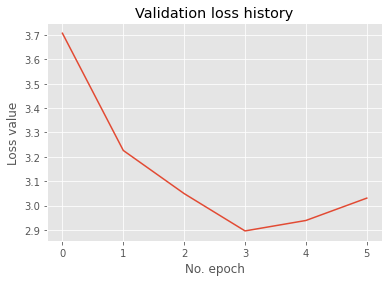

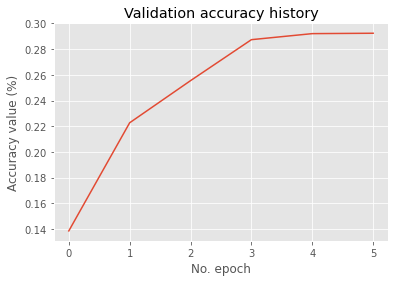

In [40]:

import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#with tf.device('/gpu:0'): 
#    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))

NUM_EPOCHS = 20
INIT_LR = 1e-3
BATCH_SIZE = 50

cifar100_mnist = tf.keras.datasets.cifar100

(train_images, train_labels), (test_images, test_labels) = cifar100_mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

droprate = 0.2
verbosity = 1
num_classes =100
input_shape = (32,32,3)

if K.image_data_format() == "channels_first":
    train_images_cnn = train_images.reshape((train_images.shape[0], 3, 32, 32))
    test_images_cnn = test_images.reshape((test_images.shape[0], 3, 32, 32))
else:
    train_images_cnn = train_images.reshape((train_images.shape[0], 32, 32, 3))
    test_images_cnn = test_images.reshape((test_images.shape[0], 32, 32, 3))

#inputs = tf.keras.Input(shape=(input_shape))

class MyModel(tf.keras.Model):
    def __init__(self, num_classes=100):
        super(MyModel,self).__init__(name='my_model')
        self.num_classes=num_classes
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu')
        
        self.batch = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.flatten1 = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(1000,activation='relu')
        self.dense_2 = tf.keras.layers.Dense(512,activation='relu')
        self.dense_3 = tf.keras.layers.Dense(256,activation='relu')
        self.dense_4 = tf.keras.layers.Dense(num_classes,activation='sigmoid')
        
    def call(self,inputs):
        a=self.conv1(inputs)
        b=self.conv2(a)
        
        c=self.flatten1(b)
        
        d=self.dense_1(c)
        e=self.dropout(d)
        
        f = self.dense_2(e)
        g=self.dropout(f)
        
        #h = self.dense_3(g)
        #i=self.dropout(h)
        
        return self.dense_4(g)
    
    def compute_output_shape(self,input_shape):
        shape=tf.TensorShape(input_shape).as_list()
        shape[-1]=self.num_classes
        return tf.TensorShape(shape)

model = MyModel(100)

opt = tf.optimizers.Adam(learning_rate=INIT_LR)
opt2 = tf.optimizers.SGD(lr=INIT_LR, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer= opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

call_back = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
            tf.keras.callbacks.TensorBoard(log_dir='.\logs',histogram_freq=1)]

H=model.fit(train_images_cnn, train_labels,epochs=NUM_EPOCHS,callbacks=call_back,validation_split=0.2)

test_loss, test_acc = model.evaluate(test_images_cnn, test_labels)

probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
print('Test accuracy:', test_acc)
predictions = model.predict(test_images_cnn)

# Visualize history
# Plot history: Loss
plt.plot(H.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(H.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()
